In [1]:
import numpy as np
import iisignature
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly import tenalg

In [2]:
#Function to generate execute the l X (4) to a tensor belonging to I2^N
#This Function allows to  map the set of model parameters from I2^N to I4^N
def tx4(tensor):
    tensor_shape = tensor.shape
    tensor_dim = len(tensor_shape)

    if tensor_dim == 1 and tensor_shape[0] == 1:
        new_tensor = tl.zeros((4))
        new_tensor[3] = tensor[0]
        return new_tensor

    new_shape = (4,) * (tensor_dim + 1) 
    new_tensor = tl.zeros(new_shape)

    index_slices = tuple(slice(0, tensor_shape[i]) for i in range(tensor_dim)) + (3,) 

    new_tensor[index_slices] = tensor 

    return new_tensor

#Applies the previous function to a sequence of tensors, this will be applied to the model palamenter l in I2^N
def lx4(l):
    l4=[]
    for tensor in l:
        l4.append(tx4(tensor))
    return l4


In [3]:
#Generates a 1-d brownian motion
def brownian_motion(n_steps, T):
    dt = T / n_steps  
    dW = np.sqrt(dt) * np.random.randn(n_steps, 1)  
    W = np.cumsum(np.insert(dW, 0, 0, axis=0), axis=0) 
    return W

In [4]:
#Applies the lead_lag_transformation to the add-time brownian motion (t,Wt)
def lead_lag_transform(W, T):

    n_steps = W.shape[0] - 1  
    time_grid = np.linspace(0, T, n_steps + 1).reshape(-1, 1)  

    # Extend to (t, W_t)
    extended_path = np.hstack((time_grid, W))

    # Lead-lag transformation
    lead = np.repeat(extended_path, 2, axis=0)[:-1]  # Duplicate each row except last
    lag = np.roll(lead, shift=-1, axis=0)  # Shift lag values

    # Ensure last point is duplicated properly
    lag[-1] = lag[-2]

    # Construct lead-lag path: (t_lead, W_lead, t_lag, W_lag)
    lead_lag_path = np.hstack((lead, lag))

    return lead_lag_path

In [5]:
def compute_signature(path, level):
    sign=iisignature.sig(path, level)
    return sign

In [6]:
#Transform the signature rappresented as a flat array by iisignature in a list of tensors
def signature_to_tensor_list(signature, d, level):
    sig=np.insert(signature, 0, 1.0)
    tensor_list = []
    index = 0
    
    for k in range(level + 1):
        shape = (d,) * k  # Shape (d, d, ..., d) for level k
        size = np.prod(shape) if k > 0 else 1  # Compute number of elements
        tensor_k = tl.tensor(sig[index : index + size].reshape(shape)) if size > 0 else tl.tensor([1.0])
        tensor_list.append(tensor_k)
        index += size
    
    return tensor_list

In [7]:
#Defines the inner product between two sequence of tensors
def inner_prod(l,W):
    somma=0
    for i in range(len(l)):
        somma+=tenalg.inner(l[i], W[i])
    return somma

In [12]:
#Function to generate a random I2^N tensor
def generate_tensors_I2N(N_max=4):  
    tensor_list = []

    for N in range(N_max):
        shape = (2,) * N  # Shape (2,2,2,...,2) for N > 0
        if N > 0:
            tensor = tl.tensor(np.random.uniform(low=0/10, high=1/20, size=shape))  # Tensor with uniform values
        else:
            tensor = tl.tensor([np.random.uniform(low=0/10, high=1/20)])  
        
        tensor_list.append(tensor)

    return tensor_list

In [9]:
#Setting the parameters
n=200
T=1
N=5
dim_sig=iisignature.siglength(4, N)  
x=1

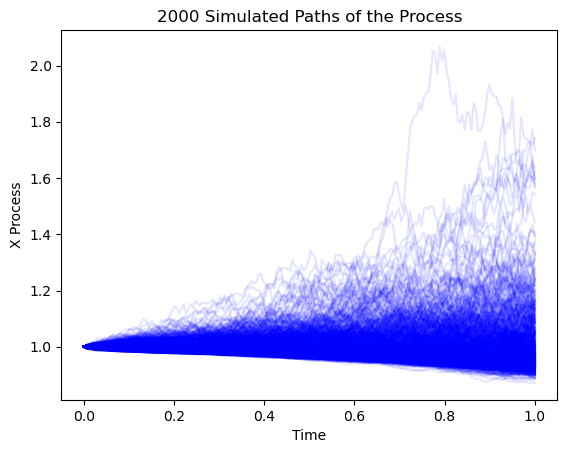

In [11]:
#Generating 1000 paths
l = generate_tensors_I2N(4)
l4=lx4(l)
num_paths=1000
for _ in range(num_paths):
    W = brownian_motion(n, T)
    W_ll = lead_lag_transform(W,T)

    # Initialize signature
    sig_total = np.zeros(dim_sig)
    sig_total[0] = 1.0

    X = np.zeros(n)
    X[0] = x  # Initial condition

    for k in range(1, n):
        segment = W_ll[2*(k-1):2*k+1, :]
        sig_segment = compute_signature(segment, N)
        sig_total = iisignature.sigcombine(sig_total, sig_segment, 4, N)
        sig_total_tensor = signature_to_tensor_list(sig_total, 4, N)
        X[k] = X[0] + inner_prod(l4,sig_total_tensor[1:])  

    plt.plot(np.linspace(0, T, n), X, alpha=0.1, color='blue')

# Final plot settings
plt.xlabel("Time")
plt.ylabel("X Process")
plt.title(f"2000 Simulated Paths of the Process")
plt.show()